# Book-Oracle

Book-Oracle is a book recommendation apps which suggest books based on preferences.

## Import Libraries

In [586]:
import pandas as pd
import numpy as np

#modelling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from transformers import pipeline
from tqdm import tqdm
import nltk



#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

## Import Data

In [587]:
# Import data 
df = pd.read_csv('data/Users.csv')
df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.00
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.00
4,5,"farnborough, hants, united kingdom",NaN


## Data Cleaning for Each Table

In [588]:
#clean column names to snakecase
df.columns = df.columns.str.replace('-','_')
df.columns = df.columns.str.lower()
df


,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.00
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.00
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.00
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [589]:
#check for duplicates
df.duplicated().value_counts()

False    278858
Name: count, dtype: int64

## Clean Datatypes

In [590]:
#check datatypes
df.dtypes

user_id       int64
location     object
age         float64
dtype: object

In [591]:
df['age'].fillna(0, inplace=True)

In [592]:
#change datatype of location and age
df['location'] = df['location'].astype('str')
df['age'] = df['age'].astype(int)


## Clean Values

### Age

In [593]:
#check values of age
df['age'].unique()

array([  0,  18,  17,  61,  26,  14,  25,  19,  46,  55,  32,  24,  20,
        34,  23,  51,  31,  21,  44,  30,  57,  43,  37,  41,  54,  42,
        50,  39,  53,  47,  36,  28,  35,  13,  58,  49,  38,  45,  62,
        63,  27,  33,  29,  66,  40,  15,  60,  79,  22,  16,  65,  59,
        48,  72,  56,  67,   1,  80,  52,  69,  71,  73,  78,   9,  64,
       103, 104,  12,  74,  75, 231,   3,  76,  83,  68, 119,  11,  77,
         2,  70,  93,   8,   7,   4,  81, 114, 230, 239,  10,   5, 148,
       151,   6, 101, 201,  96,  84,  82,  90, 123, 244, 133,  91, 128,
        94,  85, 141, 110,  97, 219,  86, 124,  92, 175, 172, 209, 212,
       237,  87, 162, 100, 156, 136,  95,  89, 106,  99, 108, 210,  88,
       199, 147, 168, 132, 159, 186, 152, 102, 116, 200, 115, 226, 137,
       207, 229, 138, 109, 105, 228, 183, 204,  98, 223, 113, 208, 107,
       157, 111, 146, 118, 220, 143, 140, 189, 127])

In [596]:
count_above_100 = (df['age'] > 100).sum()
count_above_100

0

In [595]:
# remove age outlier >100
df = df.drop(df[df['age'] > 100].index)

## Clean Location

### Split Column Country into three Columns: City, State, Country 

In [597]:
#split the values of location into three different columns: city, state, country
df[['city', 'state', 'country']] = df['location'].str.split(', ', n=2, expand=True)

In [598]:
# remove column 'location' as it is replaced by the three newly created columns: city, state, country
df = df.drop('location', axis=1)

In [599]:
#remove commas from city, state, country
df['country'] = df['country'].str.replace(',', '')
df['city'] = df['city'].str.replace(',', '')

In [600]:
df.head()

,user_id,age,city,state,country
0,1,0,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,0,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,0,farnborough,hants,united kingdom


In [601]:
#check data type
df.dtypes

user_id     int64
age         int64
city       object
state      object
country    object
dtype: object

In [602]:
#check for missing values in newly created columns
df.isna().sum()

user_id       0
age           0
city          0
state         1
country    4573
dtype: int64

#### Country Values

In [603]:
#clean missing country values 
nan_country_rows = df[df['country'].isna()]
nan_country_rows.tail(100)

,user_id,age,city,state,country
273109,273110,51,arco,,None
273122,273123,0,sebastopol,,None
273138,273139,0,key west,,None
273177,273178,0,accra,greater accra,None
273189,273190,71,coconut grove,,None
...,...,...,...,...,...
278624,278625,36,savona,,None
278651,278652,0,murrieta,,None
278697,278698,0,pasadena,maryland,None
278716,278717,53,mayagüez,puerto rico,None


In [681]:
#check missing state values 
na_country_rows = df[df['country'] == 'n/a']
na_country_rows.head(100)

,user_id,age,city,state,country


In [673]:
df['country'] = df['country'].replace('n/a', '')

In [657]:
#check missing state values 
na_country_rows = df[df['country'] == 0]
na_country_rows.head(100)

,user_id,age,city,state,country


##### Use Mapping Table to Fill Missing Country Values

In [658]:
#Import mapping table for missing values in country and create a new dataframe
worldcities_df = pd.read_csv('data/worldcities.csv')
worldcities_df.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.69,139.69,Japan,JP,JPN,Tōkyō,primary,"37,732,000.00",1392685764
1,Jakarta,Jakarta,-6.17,106.83,Indonesia,ID,IDN,Jakarta,primary,"33,756,000.00",1360771077
2,Delhi,Delhi,28.61,77.23,India,IN,IND,Delhi,admin,"32,226,000.00",1356872604
3,Guangzhou,Guangzhou,23.13,113.26,China,CN,CHN,Guangdong,admin,"26,940,000.00",1156237133
4,Mumbai,Mumbai,19.08,72.88,India,IN,IND,Mahārāshtra,admin,"24,973,000.00",1356226629


In [659]:
# Create a dictionary mapping cities to countries
city_country_mapping = dict(zip(worldcities_df['city'], worldcities_df['country']))

In [660]:
# Change Dictionary to lower case to ensure case insensitive mapping
mapping_dict = {key.lower(): value.lower() for key, value in city_country_mapping.items()}


In [661]:
# Mapping of city and country to fill missing values in country
df['country'] = df['country'].fillna(df['city'].map(mapping_dict))

In [662]:
#check remaining missing values in country
df['country'].isna().sum()

0

In [663]:
df = df.dropna(subset=['country'])

#### State Value

In [ ]:
#Remove column state
df = df.drop('state', axis=1)


In [685]:
df.head()

,user_id,age,city,country
0,1,0,nyc,usa
1,2,18,stockton,usa
2,3,0,moscow,russia
3,4,17,porto,portugal
4,5,0,farnborough,united kingdom


#### City Values

In [689]:
# remove numbers from city names
df['city'] = df['city'].replace('\d', '', regex=True)

In [547]:
#df_mapping = df_mapping.fillna({'country': df_mapping['city'].map(city_country_mapping)})
#df['country'] = df['country'].combine_first(df['city'].map(city_country_mapping))

In [548]:

# Fill NaN values in 'country' column with mapped values only where 'country' is NaN
#df = df['country'].fillna(df['city'].map(city_country_mapping),inplace=True)

### Final Cleanup Checks

In [694]:
#Missing Values
df.isna().sum()

user_id    0
age        0
city       0
country    0
dtype: int64

In [619]:
#check datatypes
df.dtypes

user_id     int64
age         int64
city       object
state      object
country    object
dtype: object

In [620]:
#dupliates
df.duplicated().value_counts()

False    277503
Name: count, dtype: int64

## Function Data Cleaning

In [691]:
#Import mapping table for missing values in country and create a new dataframe
worldcities_df = pd.read_csv('data/worldcities.csv')

def datacleaning_users ():
    # clean columns lables
    df.columns = df.columns.str.replace('-','_') #snakecase
    df.columns = df.columns.str.lower() #lowercase
    # clean data types
    df['age'].fillna(0, inplace=True) #fill missing age values with 0
    df['location'] = df['location'].astype('str') #change location type to str
    df['age'] = df['age'].astype(int) #change age type to int
    # clean age
    df = df.drop(df[df['age'] > 100].index) # remove age outlier >100 
    # clean location and split into three columns: country, state, city
    df[['city', 'state', 'country']] = df['location'].str.split(', ', n=2, expand=True) # #split the values of location into three different columns: city, state, country
    df = df.drop('location', axis=1) # remove column 'location' as it is replaced by the three newly created columns: city, state, country
    df['country'] = df['country'].str.replace(',', '') # remove commas from country
    df['city'] = df['city'].str.replace(',', '') # remove commas from city
    df['country'] = df['country'].replace('n/a', '') # empying 'n/a' values
    # clean country: Using a mapping table to fill in missing values and the drop remaining missing values
    city_country_mapping = dict(zip(worldcities_df['city'], worldcities_df['country'])) # Create a dictionary mapping cities to countries
    mapping_dict = {key.lower(): value.lower() for key, value in city_country_mapping.items()}   # Change Dictionary to lower case to ensure case insensitive mapping
    df['country'] = df['country'].fillna(df['city'].map(mapping_dict)) # Mapping of city and country to fill missing values in country
    df = df.dropna(subset=['country']) # drop remaining missing country values
    # clean state
    df = df.drop('state', axis=1) #Remove column state
    # clean city 
    df['city'] = df['city'].replace('\d', '', regex=True) # remove numbers from city names

    return df 

## Exploratory Data Analysis for Each Table

In [628]:
# Explore statistics
df.describe()

,user_id,age
count,"277,503.00","277,503.00"
mean,"139,424.80",20.84
std,"80,497.20",20.03
min,1.00,0.00
25%,"69,708.50",0.00
50%,"139,408.00",22.00
75%,"209,136.50",35.00
max,"278,858.00",100.00


In [690]:
# Count values
print("City Counts:")
print(df['city'].value_counts())

print("\nCountry Counts:")
print(df['country'].value_counts())

City Counts:
city
london             4096
barcelona          2659
toronto            2341
madrid             1930
sydney             1880
                   ... 
colwich               1
w. des moines         1
khanrwal              1
isabella plains       1
stranraer             1
Name: count, Length: 32431, dtype: int64

Country Counts:
country
usa                         139321
canada                       21817
united kingdom               18418
germany                      17101
spain                        13105
                             ...  
-                                1
hubei province hong kong         1
portugal portugal                1
aaa                              1
united kingdom.                  1
Name: count, Length: 1121, dtype: int64


In [695]:
filtered_df = df[df['city'].str.len() == 3]
filtered_df

,user_id,age,city,country
0,1,0,nyc,usa
64,65,0,n/a,australia
257,258,0,ljk,lj
535,536,20,hcm,vietnam
1216,1217,0,nyc,usa
...,...,...,...,...
277795,277796,24,lae,papua new guinea
277849,277850,0,n/a,bkk
278067,278068,0,ede,netherlands
278141,278142,0,n/a,italy


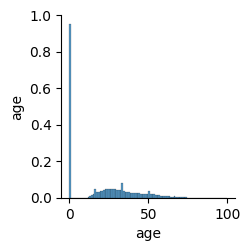

In [626]:
sns.pairplot(df[['age', 'city', 'state', 'country']])

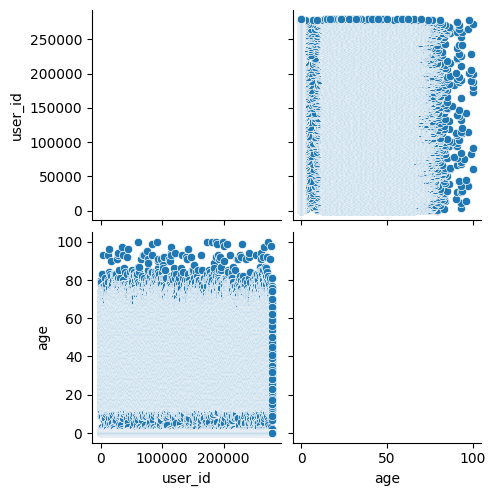

In [622]:
#correlation among features
sns.pairplot(df, diag_kind='bar')

## Merge Tables

## Data Cleaning

## Exploratory Data Analysis

## Pipline Architecture

## Sample Size

## Modelling

## Evaluation

## Error Analysis